In [1]:
# Basic Imports
import numpy as np
import h5py as h5
#from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cross_validation import KFold
import pickle
import re
import collections
import tables as tb
import ipyparallel as ipp

In [2]:
#datasets

#input data
train_val_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_train_plus_val.pkl'
test_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_test.pkl'

#k-fold indices (from a saved file)
kf_file = "/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_train_valid_KFold_idx.pkl"

#save dir for trained model 
CV_model_dir = '/projects/nikhil/ADNI_prediction/models/CV_pkls/'

inflated_train_val_file = '/projects/nikhil/ADNI_prediction/input_datasets/inflated_datasets/total_HC_vol_CT_inflated_CV_subsets_ROI_74.h5'
sub_sampx_map_file = '/projects/nikhil/ADNI_prediction/input_datasets/HC_CT_inflated_CV_subsets.h5.pkl'
#inflated_train_val_file = '/projects/nikhil/ADNI_prediction/input_datasets/total_HC_vol_CT_inflated_CV_subsets_ROI_74_test3.h5'
#sub_sampx_map_file = '/projects/nikhil/ADNI_prediction/input_datasets/HC_CT_inflated_CV_subsets_test3.h5.pkl'

AAL_roi_Name_featID_file = '/projects/nikhil/ADNI_prediction/input_datasets/CT/AAL_ROI_Name_featIDx.pkl'

inflated_train = True

boxplot_config_r = collections.defaultdict(list)
boxplot_config_R2 = collections.defaultdict(list)
boxplot_config_MSE = collections.defaultdict(list)

In [3]:
#Grab CV data with specific feature columes (independent vars) and specific clinical scale (dependent var)
def load_CV_data(in_file, kf_file, feature_cols, clinical_scale):

    data = pd.read_pickle(in_file)
    data_trunc = data[['PTID','IID'] + clinical_scale + feature_cols]
    # remove nans
    print 'NaN shape: {}'.format(np.sum(np.isfinite(data_trunc[clinical_scale[0]])))
    data_trunc = data_trunc[np.isfinite(data_trunc[clinical_scale[0]])]
    X = np.asarray(data_trunc[feature_cols],dtype=float)
    y = np.asarray(data_trunc[clinical_scale[0]],dtype=float)
    U = list(data_trunc['PTID'] + "_" + data_trunc['IID'])
    
    kf = pickle.load( open(kf_file, "rb" ) )
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []
    U_train = []
    U_valid = []
    for train, valid in kf:        
        X_train.append(X[train])
        X_valid.append(X[valid])
        y_train.append(y[train])
        y_valid.append(y[valid])
        U_train.append([U[x] for x in train])
        U_valid.append([U[x] for x in valid])
        
    #print valid
    # Return train and validation lists comprising all folds as well as unsplit data
    return {'X_train':X_train,'X_valid':X_valid,'y_train':y_train,'y_valid':y_valid,'X':X,'y':y, 'U_train':U_train,'U_valid':U_valid,'UIDs':U}

def load_data(data_path, input_node):
    data = tb.open_file(data_path, 'r')
    X = data.get_node('/' + input_node)[:]
    data.close()
    return X

def load_inflated_CV_data(in_file,feature_cols,s_fold, e_fold):
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []
    for i in np.arange(s_fold,e_fold+1,1):
        for m,modality in enumerate(feature_cols):
            train_name = 'Fold_{}_train_X_{}'.format(i,modality)
            train_data = load_data(in_file, train_name)
            #valid_name = 'Fold_{}_valid_X_{}'.format(i,modality)
            #valid_data = load_data(in_file, valid_name)
            
            if modality in ['L_HC', 'R_HC']:
                train_data = train_data.reshape(train_data.shape[0],1)            
                #valid_data = valid_data.reshape(valid_data.shape[0],1)
                
            if m ==0:
                train_X = train_data
                #valid_X = valid_data
            else:                 
                train_X = np.hstack((train_X, train_data))
                #valid_X = np.hstack((valid_X, valid_data))
                
        X_train.append(train_X)
        #X_valid.append(valid_X)
        
        train_y = load_data(in_file, 'Fold_{}_train_y'.format(i))
        #valid_y = load_data(in_file, 'Fold_{}_valid_y'.format(i))
        
        y_train.append(train_y)
        #y_valid.append(valid_y)
    
    return {'X_train':X_train,'X_valid':X_valid,'y_train':y_train,'y_valid':y_valid}
        
#Load test data
def load_test_data(in_file, feature_cols, clinical_scale):

    data = pd.read_pickle(in_file)
    data_trunc = data[clinical_scale + feature_cols]
    # remove nans
    print 'NaN shape: {}'.format(np.sum(np.isfinite(data_trunc[clinical_scale[0]])))
    data_trunc = data_trunc[np.isfinite(data_trunc[clinical_scale[0]])]
    X = np.asarray(data_trunc[feature_cols],dtype=float)
    y = np.asarray(data_trunc[clinical_scale[0]],dtype=float)
    return {'X':X, 'y':y}

def innerCVLoop(model_clf,hyper_params,fold_X, fold_y,save_model,save_model_path):
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    clf = grid_search.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0)
    clf.fit(fold_X, fold_y)
    #Save classifier
    if save_model:
        save_model(clf,save_model_path)
        
    return clf

def save_classifier(clf,save_model_path):
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    save_model_filename = save_model_path + '_' + st + '.pkl'
        
    f = open(save_model_filename, 'wb')
    pickle.dump(clf, f)
    f.close()

In [5]:
# Baseline models with non-inflated training data
# Grab specific columns as features from the original table
data = pd.read_pickle(train_val_file)
data_cols = data.columns
#regex=re.compile(".*(CT_).*")
#CT_cols_raw = [m.group(0) for l in data_cols for m in [regex.search(l)] if m] 
#print len(CT_cols_raw)
#print CT_cols_raw

CT_name_featID_dict = pd.read_pickle(AAL_roi_Name_featID_file)
CT_vals = CT_name_featID_dict.values()
#print len(CT_cols)
#print CT_cols
CT_cols = []
for ct in CT_vals:
    CT_cols.append('CT_' + ct.strip())    

print CT_cols
regex=re.compile(".*(_HC_)(\d+)")
HC_cols = [m.group(0) for l in data_cols for m in [regex.search(l)] if m] 

feature_cols = ['L_HC_VOL','R_HC_VOL'] + CT_cols
#feature_cols = CT_cols
clinical_scale = ['ADAS13']

cv_data = load_CV_data(train_val_file,kf_file, feature_cols, clinical_scale)
test_data = load_test_data(test_file, feature_cols, clinical_scale)

#Data stats for QC
print cv_data['X'].shape, test_data['X'].shape
print 'L_HC corr: {}'.format(stats.pearsonr(np.sum(cv_data['X'][:,:1],axis=1),cv_data['y']))
print 'R_HC corr: {}'.format(stats.pearsonr(np.sum(cv_data['X'][:,1:1+1],axis=1),cv_data['y']))
print 'L_HC mean vol {}:'.format(np.mean(np.sum(cv_data['X'][:,:1],axis=1)))
print 'R_HC mean vol {}:'.format(np.mean(np.sum(cv_data['X'][:,1:1+1],axis=1)))

['CT_PreCG.L', 'CT_PreCG.R', 'CT_SFGdor.L', 'CT_SFGdor.R', 'CT_ORBsup.L', 'CT_ORBsup.R', 'CT_MFG.L', 'CT_MFG.R', 'CT_ORBmid.L', 'CT_ORBmid.R', 'CT_IFGoperc.L', 'CT_IFGoperc.R', 'CT_IFGtriang.L', 'CT_IFGtriang.R', 'CT_ORBinf.L', 'CT_ORBinf.R', 'CT_ROL.L', 'CT_ROL.R', 'CT_SMA.L', 'CT_SMA.R', 'CT_OLF.L', 'CT_OLF.R', 'CT_SFGmed.L', 'CT_SFGmed.R', 'CT_ORBsupmed.L', 'CT_ORBsupmed.R', 'CT_REC.L', 'CT_REC.R', 'CT_ACG.L', 'CT_ACG.R', 'CT_DCG.L', 'CT_DCG.R', 'CT_PCG.L', 'CT_PCG.R', 'CT_CAL.L', 'CT_CAL.R', 'CT_CUN.L', 'CT_CUN.R', 'CT_LING.L', 'CT_LING.R', 'CT_SOG.L', 'CT_SOG.R', 'CT_MOG.L', 'CT_MOG.R', 'CT_IOG.L', 'CT_IOG.R', 'CT_FFG.L', 'CT_FFG.R', 'CT_PoCG.L', 'CT_PoCG.R', 'CT_SPG.L', 'CT_SPG.R', 'CT_IPL.L', 'CT_IPL.R', 'CT_SMG.L', 'CT_SMG.R', 'CT_ANG.L', 'CT_ANG.R', 'CT_PCUN.L', 'CT_PCUN.R', 'CT_PCL.L', 'CT_PCL.R', 'CT_HES.L', 'CT_HES.R', 'CT_STG.L', 'CT_STG.R', 'CT_TPOsup.L', 'CT_TPOsup.R', 'CT_MTG.L', 'CT_MTG.R', 'CT_TPOmid.L', 'CT_TPOmid.R', 'CT_ITG.L', 'CT_ITG.R']
NaN shape: 581
NaN shape:

In [6]:
# Baseline models with inflated training data
feature_cols_inflated = ['L_HC', 'R_HC', 'CT']
#feature_cols_inflated = ['CT']
cv_data_inflated = load_inflated_CV_data(inflated_train_val_file, feature_cols_inflated,1, 10)

#Data stats for QC
print cv_data_inflated['X_train'][0].shape
print 'L_HC corr: {}'.format(stats.pearsonr((cv_data_inflated['X_train'][0][:,0]),cv_data_inflated['y_train'][0]))
print 'R_HC corr: {}'.format(stats.pearsonr((cv_data_inflated['X_train'][0][:,1]),cv_data_inflated['y_train'][0]))
print 'L_HC mean vol {}:'.format(np.mean((cv_data_inflated['X_train'][0][:,0])))
print 'R_HC mean vol {}:'.format(np.mean((cv_data_inflated['X_train'][0][:,1])))

sub_sampx_dict_list = pickle.load( open(sub_sampx_map_file, "rb" ) )

(36590, 76)
L_HC corr: (-0.15386749688504342, 1.1778496735946867e-192)
R_HC corr: (-0.21886831314548072, 0.0)
L_HC mean vol 2282.69781361:
R_HC mean vol 2184.49412408:


In [15]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')

In [33]:
print cv_data['y_train'][0][:100]
print cv_data_inflated['y_train'][0][:100]

for f in np.arange(10):
    verify=[]
    pointer=0

    d = sub_sampx_dict_list[f]
    keys = d.keys()

    print len(d)

    for ind, y1 in enumerate(cv_data['y_train'][f]):
        #print d[keys[ind]]
        y2 = cv_data_inflated['y_train'][f][pointer:pointer+d[keys[ind]]]
        pointer = pointer+sub_sampx_dict_list[f][keys[ind]]
        #print 'y1 {}, y2 {}, verify: {}'.format(y1,np.mean(y2),(float(y1)-float(np.mean(y2))))
        verify.append(np.round(y1-np.mean(y2)))
    
    print np.sum(verify)

#print sub_sampx_dict_list[0]
#print (cv_data['U_train'][0])

#for f in np.arange(10):
#    a = sorted(sub_sampx_dict_list[f].keys())
#    b = sorted(cv_data['U_train'][f])
#    c = sorted(cv_data['U_valid'][f])
#    print set(a) == set(b)
#    print set(c) & set(b)



[  4.     8.    23.33  21.67  17.    17.     9.33   5.     8.33   5.    12.
  25.33  11.    18.    19.33   7.33  13.    21.    10.33  18.67   5.33
  28.33  14.67  11.    15.67  29.    18.     4.33  28.67  10.33  10.    15.67
   9.67  12.    13.33  25.    24.33  19.    31.    14.67   7.    14.33
   9.67   8.    15.    22.67  15.33  17.    32.33  34.33  19.33  23.67
   8.67  21.67   6.     8.67  19.67  16.33  27.    18.67  14.    35.67  30.
  10.33  14.33  13.33  29.33  11.67  10.    19.67   4.33   7.33  16.67
  23.33  10.     6.    12.33   7.33  25.    27.    30.    15.    31.    18.
  19.67  21.    17.33  19.33  34.    31.     6.    27.33   9.    12.67
  19.67   5.33   9.33  17.33   9.67  24.67]
[  4.     4.     4.     4.     4.     4.     4.     4.     4.     4.     4.
   4.     4.     4.     8.     8.     8.     8.     8.     8.     8.     8.
   8.     8.     8.     8.     8.     8.     8.     8.     8.     8.     8.
   8.     8.     8.     8.     8.     8.     8.    23.33  23.33  23

(76,) (76,)


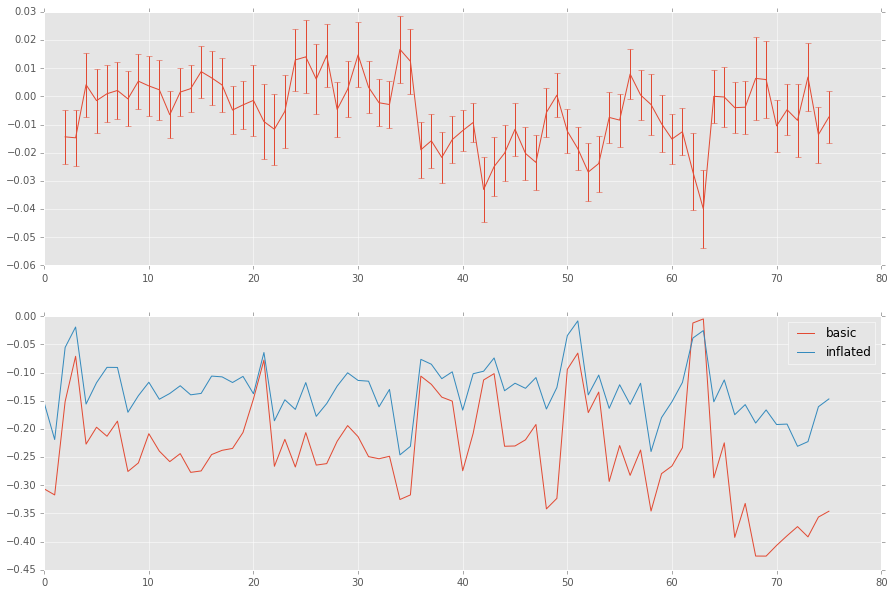

In [34]:
ct_data_roi_mean = np.mean(cv_data['X'],axis=0)
ct_data_inflated_roi_mean = np.mean(cv_data_inflated['X_train'][0],axis=0)
ct_data_roi_std_err = stats.sem(cv_data['X'],axis=0)
ct_data_inflated_roi_std_err = stats.sem(cv_data_inflated['X_train'][0],axis=0)
x=np.arange(76)
cv_data_r = []
cv_data_inflated_r = []

for i in np.arange(76):
    cv_data_r.append(stats.pearsonr(cv_data['X'][:,i], cv_data['y']))
    cv_data_inflated_r.append(stats.pearsonr(cv_data_inflated['X_train'][0][:,i],cv_data_inflated['y_train'][0]))
                               
                               
print np.shape(ct_data_roi_mean),np.shape(ct_data_inflated_roi_mean)

plt.figure()
plt.style.use('ggplot')
plt.subplot(2,1,1)
plt.errorbar(x[2:],ct_data_inflated_roi_mean[2:]-ct_data_roi_mean[2:],yerr=ct_data_roi_std_err[2:],label='diff')
#plt.errorbar(x[2:],ct_data_inflated_roi_mean[2:],yerr=ct_data_inflated_roi_std_err[2:],label='inflated')
plt.subplot(2,1,2)
plt.plot(zip(*cv_data_r)[0],label='basic')
plt.plot(zip(*cv_data_inflated_r)[0],label='inflated')
plt.legend()
plt.show()


In [ ]:
# Use this data for computing subject wise performance during outerloop cross-validation + held-out testset
fused_data_dir = '/projects/nikhil/ADNI_prediction/input_datasets/'
CV_fused_file = 'HC_CT_inflated_CV_OuterFolds_valid_partition_fused.h5'
test_fused_file = 'HC_CT_inflated_CV_OuterFolds_test_partition_fused.h5'

CV = True
L_HC_offset=11427
R_HC_offset=10519

if CV:
    cv_data_valid_X = cv_data['X_valid']     
    cv_data_valid_y = cv_data['y_valid']

    CV_fused_data = h5.File(fused_data_dir + CV_fused_file,'a')
    for f in np.arange(10):
        all_data = cv_data_valid_X[f]
        CV_fused_data.create_dataset('Fold_{}_X_L_HC'.format(f+1),data=all_data[:,:L_HC_offset])
        CV_fused_data.create_dataset('Fold_{}_X_R_HC'.format(f+1),data=all_data[:,L_HC_offset:L_HC_offset+R_HC_offset])
        CV_fused_data.create_dataset('Fold_{}_X_R_CT'.format(f+1),data=all_data[:,L_HC_offset+R_HC_offset:])#Typo : R_CT
        CV_fused_data.create_dataset('Fold_{}_y'.format(f+1),data=cv_data_valid_y[f])
    
    CV_fused_data.close()

else:
    test_fused_data = h5.File(fused_data_dir + test_fused_file,'a')
    all_data = test_data['X']
    test_fused_data.create_dataset('heldout_X_L_HC',data=all_data[:,:L_HC_offset])
    test_fused_data.create_dataset('heldout_X_R_HC',data=all_data[:,L_HC_offset:L_HC_offset+R_HC_offset])
    test_fused_data.create_dataset('heldout_X_CT',data=all_data[:,L_HC_offset+R_HC_offset:])    
    test_fused_data.create_dataset('heldout_y',data=test_data['y'])
    test_fused_data.close()


In [7]:
# K-fold validations (nested)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import grid_search
import datetime
import time
import collections
from scipy.stats import mode
from sklearn.metrics import mean_squared_error as mse

model_list = ['LR', 'LR_L1', 'SVR', 'RFR']
model_choice_id = 2
model_choice = model_list[model_choice_id]

if model_choice == 'LR':
    model_clf = LinearRegression()   
    inner_loop = False #only needed to optimize hyper-params
    feat_imp = False
    if inflated_train:
        print "no trained model yet"
    else:
        saved_model_name = 'LR_2015-10-13-16-38-28.pkl'
    
elif model_choice == 'LR_L1':
    model_clf = Lasso()
    hyper_params = {'alpha':[0.2, 0.1, 0.05, 0.01]} 
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True
    if clinical_scale[0] == 'ADAS13':
        if inflated_train:
            saved_model_name = 'LR_L1_ADAS13_inflated_train_parallel_2015-11-14-20-21-48.pkl'
        else:
            saved_model_name = 'LR_L1_ADAS13_2015-11-06-12-25-21.pkl'
    else:
        saved_model_name = 'LR_L1_MMSE_2015-10-16-16-27-29.pkl'
    
elif model_choice == 'SVR':
    model_clf = SVR()
    hyper_params = {'kernel':('linear'), 'C':[1,10]}
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True
    if clinical_scale[0] == 'ADAS13':
        if inflated_train:
            saved_model_name = 'SVR_ADAS13_inflated_train_2015-11-11-15-57-34.pkl'
        else:
            saved_model_name = 'SVR_ADAS13_2015-11-06-11-47-23.pkl'
    else:
        saved_model_name = 'SVR_MMSE_2015-10-16-18-02-11.pkl'
    
elif model_choice == 'RFR':
    model_clf = RandomForestRegressor(n_jobs=3)
    hyper_params = {'n_estimators':[10,50],'min_samples_split':[2,4]}
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True
    if clinical_scale[0] == 'ADAS13':
        if inflated_train:
            #saved_model_name = 'RFR_ADAS13_inflated_train_parallel_2015-11-10-15-01-42.pkl'
            saved_model_name = 'RFR_ADAS13_inflated_train_parallel_2015-11-16-14-21-15.pkl'
        else:
            saved_model_name = 'RFR_ADAS13_2015-11-05-18-02-11.pkl'
    else:
        saved_model_name = 'RFR_MMSE_2015-10-16-16-22-42.pkl'
else:
    print "Unknown model choice"

In [8]:
#Outer Fold Computation

def computeOuterFold(train_X, train_y, valid_X, valid_y, model_clf, hyper_params, inner_loop, save_model, save_model_path):
    import collections
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    import datetime
    import time
    import collections
    from scipy.stats import mode
    from sklearn.metrics import mean_squared_error as mse
    from scipy import stats
    
    print 'Starting Outerfold computation'
    
    hp_dict = collections.defaultdict(list) #store best hyper-parameters for each fold
    
    if inner_loop:     
        print 'Starting Inner computation'
        save_model_path_fold = save_model_path + '_fold_' 
        clf = innerCVLoop(model_clf,hyper_params,train_X, train_y,save_model,save_model_path_fold)
        for hp in hyper_params:
            hp_dict[hp].append(clf.best_estimator_.get_params()[hp])
            
        print 'Ending InnerFold computation'

    else:
        clf = model_clf
        clf.fit(fold_X,fold_y)
        
    #CV_scores
    r_train = stats.pearsonr(clf.predict(train_X),train_y)
    r_valid = stats.pearsonr(clf.predict(valid_X),valid_y)
        
    R2_train = clf.score(train_X,train_y) 
    R2_valid = clf.score(valid_X,valid_y)
        
    MSE_train = mse(clf.predict(train_X),train_y)
    MSE_valid = mse(clf.predict(valid_X),valid_y)
    
    print 'Ending OuterFold computation'
    
    return {'r_train':r_train, 'r_valid':r_valid, 'R2_train':R2_train, 'R2_valid':R2_valid,
           'MSE_train':MSE_train, 'MSE_valid':MSE_valid, 'hp_dict':hp_dict}

In [ ]:
#Parallelize!!! 
from functools import partial

save_model_path = CV_model_dir + model_choice + '_' + clinical_scale[0]
load_model_path = CV_model_dir + saved_model_name

# train a new classifer? (if false then load a single pretrained classifier based on most frequent hyperparams found previously
# This will NOT load N different classifiers each for outer-CV fold  
train_clf = True

if inflated_train:    
    cv_X_train = cv_data_inflated['X_train']
    cv_y_train = cv_data_inflated['y_train']
else: 
    cv_X_train = cv_data['X_train']
    cv_y_train = cv_data['y_train']
    
cv_X_valid = cv_data['X_valid']
cv_y_valid = cv_data['y_valid']

no_of_folds = len(cv_X_train)

save_model = False #do you want to save all classifiers per each fold? 
save_model_path = CV_model_dir + model_choice + '_' + clinical_scale[0]

if train_clf:
    CV_r_train=[] #pearson r score for each outer fold on train set
    CV_r_valid=[] #pearson r score for each outer fold on validation set

    CV_R2_train=[] #R2 score for each outer fold on train set
    CV_R2_valid=[] #R2 score for each outer fold on validation set

    CV_MSE_train=[] #MSE for each outer fold on train set
    CV_MSE_valid=[] #MSE for each outer fold on validation set
    # outer CV loop     
    rc = ipp.Client()
    dview = rc[:]
    dview.push(dict(computeOuterFold = computeOuterFold))
    dview.push(dict(innerCVLoop = innerCVLoop))
    mapfunc = partial(computeOuterFold, model_clf=model_clf, hyper_params=hyper_params, inner_loop=inner_loop, 
                  save_model=save_model, save_model_path=save_model_path)
    parallel_result = dview.map_sync(mapfunc, cv_X_train,cv_y_train,cv_X_valid,cv_y_valid)    
    hp_dict = collections.defaultdict(list)
    for pr in parallel_result:
        CV_r_train.append(pr['r_train'])
        CV_r_valid.append(pr['r_valid'])
        CV_R2_train.append(pr['R2_train'])
        CV_R2_valid.append(pr['R2_valid'])
        CV_MSE_train.append(pr['MSE_train'])
        CV_MSE_valid.append(pr['MSE_valid'])
        
        for hp in hyper_params:
            hp_dict[hp].append(pr['hp_dict'][hp])
            
    #retrain model on the entire train + valid set with most frequent hyper-params during cross-val
    if inner_loop:
        hp_mode = {}
        for hp in hyper_params:
            hp_mode[hp] = mode(hp_dict[hp])[0][0]
            
        print 'most frequent hp:' + str(hp_mode)
    
else: 
    #Grabs the best classifer as a result of N-fold nested CV along with the MSE and R2 stats of the outerloop
    print "Loading previously saved model: "
    f = open(load_model_path)
    result = pickle.load(f)
    test_clf = result['best_clf']
    CV_r_valid = result['CV_r']
    CV_R2_valid = result['CV_R2']
    CV_MSE_valid = result['CV_MSE']
    f.close()

print 'CV r (mean, std_err): ' + '{:04.2f}, {:04.2f}'.format(np.mean(zip(*CV_r_valid)[0]),stats.sem(zip(*CV_r_valid)[0]))
print 'CV R2 (mean, std_err): ' + '{:04.2f}, {:04.2f}'.format(np.mean(CV_R2_valid),stats.sem(CV_R2_valid))
print 'CV MSE (mean, std_err): ' + '{:04.2f}, {:04.2f}'.format(np.mean(CV_MSE_valid),stats.sem(CV_MSE_valid))

In [ ]:
LR_L1
CT: 
orig: most frequent hp:{'alpha': array([ 0.2])}
CV r (mean, std_err): 0.47, 0.04
CV R2 (mean, std_err): 0.21, 0.03
CV MSE (mean, std_err): 62.36, 3.47
    
infl: most frequent hp:{'alpha': array([ 0.1])}
CV r (mean, std_err): 0.45, 0.04
CV R2 (mean, std_err): 0.17, 0.02
CV MSE (mean, std_err): 65.48, 3.62
    
HC:
orig: most frequent hp:{'alpha': array([ 0.2])}
CV r (mean, std_err): 0.32, 0.04
CV R2 (mean, std_err): 0.09, 0.03
CV MSE (mean, std_err): 71.68, 4.31

infl: most frequent hp:{'alpha': array([ 0.01])}
CV r (mean, std_err): 0.32, 0.03
CV R2 (mean, std_err): 0.08, 0.02
CV MSE (mean, std_err): 72.49, 3.85
    
HC + CT
orig: most frequent hp:{'alpha': array([ 0.2])}
CV r (mean, std_err): 0.51, 0.03
CV R2 (mean, std_err): 0.25, 0.03
CV MSE (mean, std_err): 58.99, 3.50

infl: most frequent hp:{'alpha': array([ 0.1])}
CV r (mean, std_err): 0.50, 0.03
CV R2 (mean, std_err): 0.22, 0.02
CV MSE (mean, std_err): 61.46, 3.76


In [39]:
# Evaluate the test set based on most frequnt hyper-params
if inflated_train:
    save_model_path = CV_model_dir + model_choice + '_' + clinical_scale[0] + '_inflated_train_parallel'
    exemplar_X = cv_X_train[0]
    exemplar_y = cv_y_train[0]        
else:
    exemplar_X = cv_data['X']
    exemplar_y = cv_data['y']
    save_model_path = CV_model_dir + model_choice + '_' + clinical_scale[0]
        
if train_clf:
    #test_clf = LinearRegression()  
    #test_clf = Lasso(alpha=0.01)    
    #test_clf = SVR(kernel='linear',C=1)
    test_clf = RandomForestRegressor(n_estimators=50,min_samples_split=2)
   
    save_model = True    
    
    test_clf.fit(exemplar_X,exemplar_y)
    if save_model:
        classifier_model_and_stats = {'best_clf':test_clf, 'CV_R2':CV_R2_valid, 'CV_MSE':CV_MSE_valid, 'CV_r': CV_r_valid}
        save_classifier(classifier_model_and_stats,save_model_path)

    # heldout set training perf
    pearson_r_train = stats.pearsonr(test_clf.predict(exemplar_X),exemplar_y)
    R2_train = test_clf.score(exemplar_X,exemplar_y)
    MSE_train = mse(test_clf.predict(exemplar_X),exemplar_y)
    
    print "train r: " + str(pearson_r_train)
    print "train R2 score: " + str(R2_train)
    print "test R2 score: " + str(MSE_train)

# heldout set test perf
predicted_score = test_clf.predict(test_data['X'])
actual_score = test_data['y']
pearson_r_test = stats.pearsonr(predicted_score,actual_score)
R2_test = test_clf.score(test_data['X'],actual_score)
MSE_test = mse(predicted_score,actual_score)

print "test r: " + str(pearson_r_test)
print "test R2: " + str(R2_test)
print "test MSE: " + str(MSE_test)

save_plt_data = False
if save_plt_data: #save the data to be plotter later.. (montages etc..)
        montage_dir = '/projects/nikhil/ADNI_prediction/caffe_output/montage_data/'
        mydict = {'predicted_score': predicted_score, 'actual_score': actual_score}
        output = open('{}corr_data_{}_T{}.pkl'.format(montage_dir,model_choice+'_infl',1), 'wb')
        pickle.dump(mydict, output)
        output.close()

train r: (0.9796292454301917, 0.0)
train R2 score: 0.920456486902
test R2 score: 6.01007512391
test r: (0.38931303839813763, 2.6271519185359258e-05)
test R2: 0.118069850776
test MSE: 74.0870575316


In [ ]:
load_saved_boxplots = False
if load_saved_boxplots:
    boxplots_dir = '/projects/nikhil/ADNI_prediction/caffe_output/montage_data/'
    file_str = 'CV_corr_data_T11.pkl'
    pkl_file = open(boxplots_dir + file_str.format(cat), 'rb')
    boxplot_config_r = pickle.load(pkl_file)
    pkl_file.close()    
    file_str = 'CV_MSE_data_T11.pkl'
    pkl_file = open(boxplots_dir + file_str.format(cat), 'rb')
    boxplot_config_MSE = pickle.load(pkl_file)
    pkl_file.close()    

else:
    #print np.mean(zip(*CV_r_train)[0])
    print np.mean(zip(*CV_r_valid)[0])

    boxplot_config_r[model_choice].append((zip(*CV_r_valid)[0]))
    boxplot_config_R2[model_choice].append(CV_R2_valid)
    boxplot_config_MSE[model_choice].append(CV_MSE_valid)


In [ ]:
# Boxplots for CV statistics (r, mse, R2)
stat_measure_list = [boxplot_config_r,boxplot_config_MSE]
stat_measure_names = ['Pearson r', 'MSE']
from matplotlib.artist import setp
plt.figure()
font_small = 12
font_med = 16
font_large = 24
plt.style.use('ggplot')

for sm, stat_measure in enumerate(stat_measure_list):
    plt.subplot(2,1,sm+1)
    df_array = pd.DataFrame(dict([ (k,pd.Series(v[0])) for k,v in stat_measure.iteritems() ]))
    bplot = df_array.boxplot(column=stat_measure.keys(), fontsize=font_large)
    #plt.xlabel('Method',fontsize=font_large)
    plt.ylabel(stat_measure_names[sm],fontsize=font_large)
    plt.xticks(fontsize=font_med)
    plt.yticks(fontsize=font_small)
    setp(bplot['boxes'], linewidth=2)
    setp(bplot['whiskers'], linewidth=2)
    setp(bplot['fliers'], linewidth=2)
    setp(bplot['medians'], linewidth=2)
    
plt.show()

In [ ]:
# Compute scores and MSEs

y_cv_pred = test_clf.predict(exemplar_X)
y_test_pred = test_clf.predict(test_data['X'])

x_data_array = [exemplar_y,test_data['y']]
y_data_array = [y_cv_pred,y_test_pred]
lable_array = ['CV train performance','test performance']

# only test perf
#x_data_array = [test_data['y']]
#y_data_array = [y_test_pred]
#lable_array = ['test performance']

plt.figure()
font_small = 8
font_med = 16
font_large = 24
no_of_plots = len(lable_array)
plt.style.use('ggplot')
plt_col = no_of_plots
plt_row = 1

for i in np.arange(no_of_plots):
    x = x_data_array[i]
    y = y_data_array[i]

    plt.subplot(plt_row,plt_col,i+1)
    plt.scatter(x, y, c='crimson', label=lable_array[i],s=40)
    fit = np.polyfit(x,y,1)
    fit_fn = np.poly1d(fit) 
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    if p_value < 0.0001:
        p_value_sig = '<0.0001'
    else:
        p_value_sig = str(p_value)
        
    label_str = 'r-value: {:04.2f}'.format(r_value) + '\n' + 'p-value: ' + p_value_sig + '\n' + 'std_err: {:04.2f}'.format(std_err) 
    # fit_fn is now a function which takes in x and returns an estimate for y
    plt.plot(x, fit_fn(x),linewidth=3, label=label_str)
    plt.title(model_choice,fontsize=font_large)
    plt.xlabel('Actual Score',fontsize=font_large)
    plt.ylabel('Predicted Score',fontsize=font_large)            
    plt.legend(fontsize=font_med,loc=2)

if feat_imp:
    plt.figure()
    #plt.subplot(plt_row,plt_col,4)
    x_pos = np.arange(len(feature_cols))
    
    if model_choice == 'RFR':
        feature_wts = test_clf.feature_importances_
    elif model_choice == 'SVR':
        feature_wts = np.squeeze(test_clf.coef_)
    elif model_choice == 'LR_L1':
        feature_wts = np.squeeze(test_clf.coef_)
    else: 
        print 'no feature_wt vector found'
        
    sorted_feat_idx = np.argsort(np.abs(feature_wts))[::-1]        
    plt.bar(x_pos,feature_wts[sorted_feat_idx],color='crimson')
    plt.ylabel('Feature Importance',fontsize=font_large)
    #Sort the feature name list as well 
    sorted_feature_cols = []
    for i,sort_idx in enumerate(sorted_feat_idx):
        sorted_feature_cols.append(feature_cols[sort_idx])

    plt.xticks(x_pos,sorted_feature_cols,rotation=70,fontsize=font_small)
    
plt.show()

In [ ]:
#Plot montages (across methods)
mont_data_dir = '/projects/nikhil/ADNI_prediction/caffe_output/montage_data/'
cats = ['LR_L1','SVR','RFR','LR_L1_infl','SVR_infl','RFR_infl'] #Montage Categories: methods / modalities
file_str = 'corr_data_{}_T1.pkl'
#cats = ['L_HC','R_HC','HC','HC_CT'] #Montage Categories: methods / modalities
#file_str = 'corr_data_{}_T11.pkl'

n_rows = 2
n_cols = 3

plt.figure()
plt.style.use('ggplot')
font_small = 8
font_med = 16
font_large = 24

for c, cat in enumerate(cats):
    if cat == 'HC_CT':
        file_str = 'corr_data_{}_T11.pkl'
        
    pkl_file = open(mont_data_dir + file_str.format(cat), 'rb')
    montage_data = pickle.load(pkl_file)
    pkl_file.close()    
    x = montage_data['predicted_score']
    y = montage_data['actual_score']
        
    plt.subplot(n_rows,n_cols,c+1)
    plt.scatter(x, y, c='crimson',s=20)
    fit = np.polyfit(x,y,1)
    fit_fn = np.poly1d(fit) 
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)      
    if p_value < 0.0001:
        p_value_sig = '<0.0001'
    else:
        p_value_sig = '{:.5f}'.format(p_value)
        
    label_str = 'r-value: {:04.2f}'.format(r_value) + '\n' + 'p-value: ' + p_value_sig + '\n' + 'std_err: {:04.2f}'.format(std_err) 
    # fit_fn is now a function which takes in x and returns an estimate for y
    plt.plot(x, fit_fn(x),linewidth=3, label=label_str)        
    title_str = 'Heldout Testset, modality: {}'.format(cat)  #heldout Test set
    plt.title(title_str,fontsize=font_med)
    plt.xlabel('Actual Score',fontsize=font_med)
    plt.ylabel('Predicted Score',fontsize=font_med)            
    plt.legend(fontsize=font_med,loc=2)

plt.show()

In [ ]:
# Additional Scripts 
# Concat of Train + Valid (to generate multi-folds)
train_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_train.pkl'
valid_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_valid.pkl'
t_data = pd.read_pickle(train_file)
v_data = pd.read_pickle(valid_file)
frames = [t_data, v_data]
result = pd.concat(frames)
result.to_pickle("/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_train_plus_val.pkl")

# Generatng K-Folds
#sampx = 100 #Train + Valid samples
#foldx = 10   
#kf = KFold(sampx, n_folds=foldx,shuffle=True)

#for train, test in kf:
#    print("%s %s" % (train, test))

In [ ]:
#save k-fold UIDs
kf_uid_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_train_valid_KFold_UIDs.pkl'
train_valid_KFold_UIDs={'train_UIDs':cv_data['U_train'] ,'valid_UIDs':cv_data['U_valid']}
f = open(kf_uid_file, 'wb')
pickle.dump(train_valid_KFold_UIDs, f)
f.close()